# Lunar Lander Continuous v2

### Описание задачи

**Характеристики окружения**  
* Эпизодическая среда
* Детерминированная / Стохастическая среда
* Непрерывная среда (пространство действий)
* Среда с полной информацией

**Цель игры**  
Требуется посадить космический модуль в обозначенную зону, управляя его двигателями.<br>Посадочная площадка всегда находится в координатах (0;0). Запас топлива - бесконечен.<br>Среда считается решённой, когда агент набирает не менее 200 балов за эпизод.

**Окружение**

<img src="https://gymnasium.farama.org/_images/lunar_lander.gif" width="750" align="center">

**Состояние**

Вектор из 8 показателей:
* x координата модуля
* y координата модуля
* vx, горизонтальная скорость
* vy, вертикальная скорость
* θ, ориентация в пространстве
* vθ, угловая скорость
* Левая нога модуля коснулась земли (bool)
* Правая нога модуля коснулась земли (bool)

**Пространство действий**

Пространство действий описывается двумя вещественными координатами. Первая координата действия определяет дроссельную заслонку главного двигателя, а вторая координата — дроссельную заслонку боковых ускорителей.

**Терминальные состояния**  

Эпизод заканчивается, когда посадочный модуль приземляется, разбивается или улетает за пределы области видимости.

**Функция вознаграждения**  

Награда представляет собой комбинацию того, насколько близко посадочный модуль находится к посадочной площадке и насколько его скорость близка к нулевой, по сути, чем ближе он к посадке, тем выше награда. Агент получает небольшую отрицательную награду каждый раз, когда он включает двигатели. Это делается для того, чтобы научить агента сажать модуль, как можно быстрее и эффективнее. Также агента получает -100 баллов, если модуль разбивается и +100 если удаётся посадить модуль.

**Полезные ссылки**
* https://gymnasium.farama.org/environments/box2d/lunar_lander

***

### Установка зависимостей, импорт библиотек

**Установка зависимостей**

**Импорт библиотек**

In [36]:
import os
import sys
import PIL
import math
import json
import random
import numpy as np
import pandas as pd
import shutil as sh
from glob import glob
from pytz import timezone
from datetime import datetime
from collections import deque
from base64 import b64encode
from IPython.display import display, clear_output, HTML
from matplotlib import pyplot as plt
import seaborn as sns

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [38]:
import gymnasium as gym

In [39]:
import warnings
warnings.simplefilter("ignore")

### Выбор временной зоны

In [40]:
TZ = timezone('Europe/Moscow')

### Определение устройства для обучения и инференса моделей

In [41]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

### Определение путей и директорий

In [42]:
env_dir = 'models\\DDPG\\lunar_lander'

### Вспомогательные методы

**Отображение состояния среды, сохранение записи эпизода, просмотр записи эпизода**

In [43]:
def display_state(state):
    plt.figure(figsize=(8, 6))
    plt.imshow(state)
    plt.axis('off')


def record_episode(eps_frames, records_dir, agent_name, exp_id, eps_num):
    record_path = os.path.join(records_dir, f'{agent_name}_{exp_id}_eps-{eps_num}.mp4')
    eps_frame_dir = 'episode_frames'
    os.mkdir(eps_frame_dir)

    for i, frame  in enumerate(eps_frames):
        PIL.Image.fromarray(frame).save(os.path.join(eps_frame_dir, f'frame-{i+1}.png'))

    os.system(f'ffmpeg -r 16 -i {eps_frame_dir}/frame-%1d.png -vcodec libx264 -b 10M -y "{record_path}"');
    sh.rmtree(eps_frame_dir)


def show_episode_records(records_dir):
    record_paths = glob(os.path.join(records_dir, "*.mp4"))
    html_str = ''
    for i, record_path in enumerate(record_paths):
        mp4 = open(record_path, 'rb').read()
        data = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
        html_str += f'EPISODE # {i+1}<br><video width=500 controls><source src="{data}" type="video/mp4"></video><br><br>'
    return HTML(html_str)


**Создание директорий для логирования результатов, сохрание параметров и метрик экспериментов**

In [44]:
def create_exp_dirs(env_dir, exp_params):
    dirs = dict()
    dirs['exp'] = os.path.join(env_dir, 'experiments', exp_params["algorithm_name"], exp_params["exp_id"])
    dirs['training'] = os.path.join(dirs['exp'], 'training')
    dirs['evaluation'] = os.path.join(dirs['exp'], 'evaluation')
    os.makedirs(dirs['training'], exist_ok=True)
    os.makedirs(dirs['evaluation'], exist_ok=True)
    return dirs


def save_exp_params(params, exp_dir):
    params_path = os.path.join(exp_dir, 'experiment_params.json')
    with open(params_path, 'w') as f:
        json.dump(params, f)


def save_metrics(metrics, metrics_type, train_eps_dir):
    metrics_path = os.path.join(train_eps_dir, f'{metrics_type}_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

## Обзор окружения


In [45]:
def create_env():
    return gym.make('LunarLanderContinuous-v2',
                gravity=np.clip(
                    np.random.normal(loc=-8.0, scale=1.0),
                    a_min=-11.99,
                    a_max=-0.01
                ),
                enable_wind=np.random.choice([True, False]),
                wind_power=np.clip(
                    np.random.normal(loc=10.0, scale=1.0),
                    a_min=0.01,
                    a_max=19.99
                ),
                turbulence_power=np.clip(
                    np.random.normal(loc=1.0, scale=0.5),
                    a_min=0.01,
                    a_max=1.99
                ),
                max_episode_steps=400,
                render_mode='rgb_array')

    # return gym.make('LunarLanderContinuous-v2', max_episode_steps=400, render_mode='rgb_array')

### Создание окружения, старт нового эпизода, отображение начального состояния

Current state: [-0.00513601  1.4066534  -0.5201219  -0.18963936  0.00584976  0.11569586
  0.          0.        ]


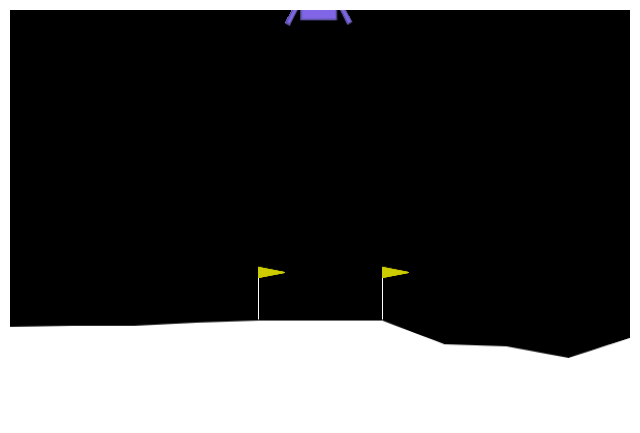

In [46]:
env = create_env()
state, info = env.reset()
state_rgb = env.render()

print(f'Current state: {state}')
display_state(state_rgb)

In [47]:
env.observation_space

Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

In [48]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

In [49]:
env.action_space.sample()

array([-0.8599076,  0.8426069], dtype=float32)

### Пошаговое тестирование окружения

Current state: [-0.02989054  1.3778285  -0.488036   -0.30139223  0.0320617   0.09806865
  0.          0.        ]
Action: [-0.8409396  0.2231982]
Reward: -0.44637115998068566
Done: (False, False)


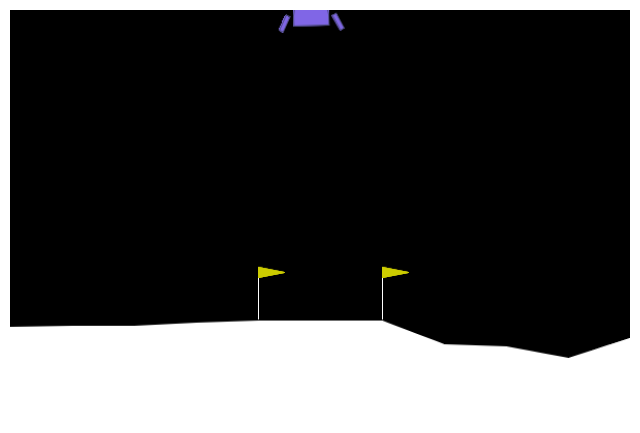

In [50]:
action = env.action_space.sample()

for i in range(5):
    next_state, reward, terminated, truncated, info = env.step(action)
    next_state_rgb = env.render()

print(f'Current state: {next_state}\nAction: {action}\nReward: {reward}\nDone: {terminated, truncated}')
display_state(next_state_rgb)

In [51]:
env.close()

## Тестирование агента со случайной стратегией

### Методы для запуска эпизодов и оценки агента

In [52]:
def run_episode(env, agent):
    state, info = env.reset()
    step_count = 0
    total_reward = 0
    frames = list()
    done = False

    while not done:
        action = agent.choose_action(state, mode='exploitation')
        next_state, reward, terminated, truncated, info = env.step(action)
        step_count += 1
        total_reward += reward
        done = terminated or truncated
        state = next_state
        frames.append(env.render())

    win = True if total_reward >= 200 else False
    frames.extend([env.render()] * 3)
    return win, total_reward, step_count, frames


def evaluate_agent(env, agent, exp_params, exp_dirs):
    for eps_num in range(1, exp_params['evaluation']['episode_count'] + 1):
        eps_win, total_reward, eps_step_count, eps_frames = run_episode(env, agent)
        record_episode(eps_frames, exp_dirs['evaluation'], exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

        print(f'EPISODE # {eps_num}')
        if eps_win:
            print('Agent reached the Goal 🏆')
        else:
            print('Agent was defeated ☠️')
        print(f'Total reward: {round(total_reward, 2)}')
        print(f'Number of steps: {eps_step_count}')
        print('-' * 50)

### Случайный агент

In [53]:
class RandomAgent:

  def __init__(self, env, params):
      self._env = env
      self._params = params

  @property
  def name(self):
      return f"{self._params['algorithm_name']}_agent"


  def choose_action(self, state, mode='exploitation'):
      return self._env.action_space.sample()

### Параметры эксперимента

In [54]:
exp_params = {
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'algorithm_name': 'random',
    'seed': 21,
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(env_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Оценка агента

In [56]:
env = create_env()
random_agent = RandomAgent(env, exp_params)
evaluate_agent(env, random_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Total reward: -493.2
Number of steps: 126
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Total reward: -646.23
Number of steps: 168
--------------------------------------------------
EPISODE # 3
Agent was defeated ☠️
Total reward: -42.97
Number of steps: 87
--------------------------------------------------


In [25]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование агента с эвристической стратегией

### Эвристический агент

In [26]:
from gymnasium.envs.box2d.lunar_lander import heuristic

In [27]:
class HeuristicAgent:

  def __init__(self, env, params):
      self._env = env
      self._params = params

  @property
  def name(self):
      return f"{self._params['algorithm_name']}_agent"


  def choose_action(self, state, mode='exploitation'):
      return heuristic(self._env, state)

### Параметры эксперимента

In [31]:
exp_params = {
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'algorithm_name': 'heuristic',
    'seed': 21,
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(env_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Оценка агента

In [30]:
env = create_env()
heuristic_agent = HeuristicAgent(env, exp_params)
evaluate_agent(env, heuristic_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent reached the Goal 🏆
Total reward: 240.21
Number of steps: 260
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Total reward: 112.24
Number of steps: 400
--------------------------------------------------
EPISODE # 3
Agent reached the Goal 🏆
Total reward: 264.58
Number of steps: 314
--------------------------------------------------


In [ ]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование DDPG-агента

### Описание алгоритма

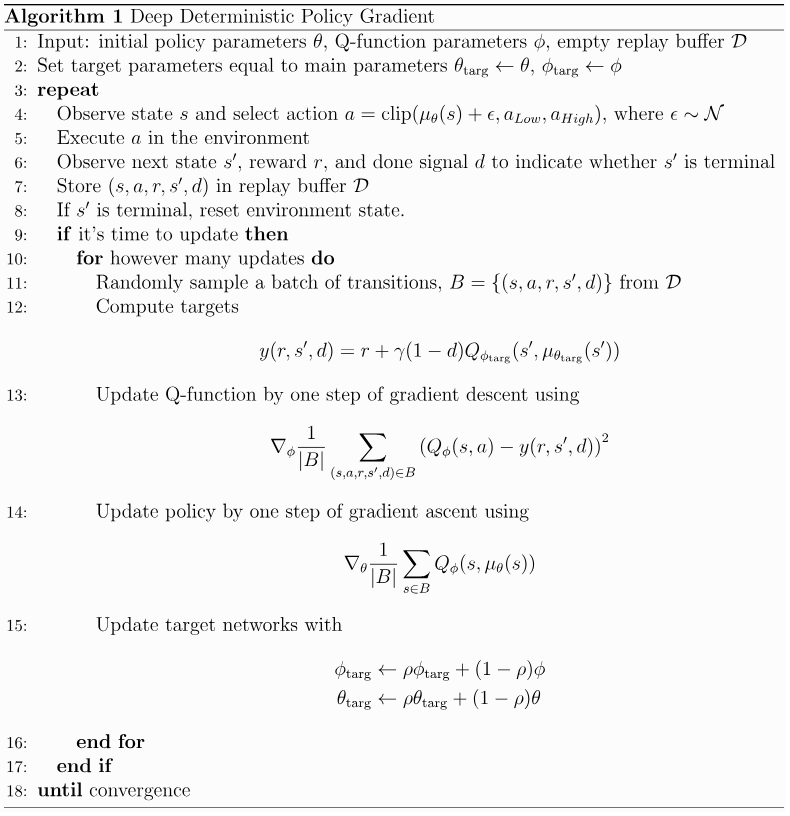

### Классы для нормализации и добавления шума в действия

In [ ]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound = self.action_space.low
        upper_bound = self.action_space.high
        action = (action + 1) * 0.5 * (upper_bound - low_bound) + low_bound
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        pass


class GaussNoise:

    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def get_action(self, action):
        noisy_action = np.random.normal(action, self.sigma)
        return noisy_action

### Value и Policy сети

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs + num_actions, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.net(x)
        return x


class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=512):
        super().__init__()
        self.net =  nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_actions)
        )

    def forward(self, state):
        return self.net(state)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        action = self.forward(state)
        action = action.detach().cpu().numpy()[0]
        action = np.clip(action, -1.0, 1.0)
        return action

### Буфер памяти

In [ ]:
class ReplayBuffer:

    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    @property
    def is_exp_enough(self):
        if len(self.buffer) < 1000:
            return False
        return True


    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)


    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        return states, actions, rewards, next_states, dones


    def __len__(self):
        return len(self.buffer)

### DDPG-агент

In [ ]:
class DDPGAgent:

    def __init__(self, env, buffer, params):
        self._env = env
        self._params = params

        self._buffer = buffer
        self._action_noiser = GaussNoise(params['training']['action_noise_sigma'])

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self._value_net = ValueNetwork(state_dim, action_dim).to(DEVICE)
        self._target_value_net = ValueNetwork(state_dim, action_dim).to(DEVICE)
        for target_params, behavior_params in zip(self._target_value_net.parameters(), self._value_net.parameters()):
            target_params.data.copy_(behavior_params.data)
        self._value_optimizer = optim.Adam(self._value_net.parameters(),
                                           lr=params['training']['value_lr'],
                                           weight_decay=1e-6)

        self._policy_net = PolicyNetwork(state_dim, action_dim).to(DEVICE)
        self._target_policy_net = PolicyNetwork(state_dim, action_dim).to(DEVICE)
        for target_params, behavior_params in zip(self._target_policy_net.parameters(), self._policy_net.parameters()):
            target_params.data.copy_(behavior_params.data)
        self._policy_optimizer = optim.Adam(self._policy_net.parameters(),
                                            lr=params['training']['policy_lr'],
                                            weight_decay=1e-6)


    def choose_action(self, state, mode='exploitation'):
        if mode == 'exploration':
            action = self._policy_net.get_action(state)
            action = self._action_noiser.get_action(action)
            return action

        self._policy_net.eval()
        with torch.no_grad():
            return self._policy_net.get_action(state)


    def save_new_transition(self, state, action, reward, next_state, done):
        self._buffer.push(state, action, reward, next_state, done)


    def learn(self):
        if not self._buffer.is_exp_enough:
            return

        self._value_net.train()
        self._policy_net.train()

        states, actions, rewards, next_states, dones = self._buffer.sample(self._params['training']['batch_size'])
        states = torch.tensor(states, dtype=torch.float32).to(DEVICE)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.float32).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(DEVICE)
        dones = torch.tensor(np.float32(dones)).unsqueeze(1).to(DEVICE)

        policy_loss = -self._value_net(states, self._policy_net(states)).mean()

        values = self._value_net(states, actions)
        next_actions = self._target_policy_net(next_states)
        target_values = self._target_value_net(next_states, next_actions.detach())
        expected_values = target_values * self._params['training']['gamma'] * (1 - dones) + rewards
        expected_values = torch.clamp(expected_values,
                                      self._params['training']['value_lower_bound'],
                                      self._params['training']['value_upper_bound'])
        value_loss = nn.MSELoss()(values, expected_values.detach())

        self._policy_optimizer.zero_grad()
        policy_loss.backward()
        self._policy_optimizer.step()

        self._value_optimizer.zero_grad()
        value_loss.backward()
        self._value_optimizer.step()

        self._soft_update_target_models()


    def save_agent_state(self, log_dir):
        raise NotImplementedError(f'This method isn\'t implemented in {self.__class__.__name__} class.')


    def load_agent_state(self, log_dir):
        raise NotImplementedError(f'This method isn\'t implemented in {self.__class__.__name__} class.')


    def _soft_update_target_models(self):
        tau = self._params['training']['tau']

        for target_params, behavior_params in zip(self._target_value_net.parameters(), self._value_net.parameters()):
            target_params.data.copy_(tau * behavior_params.data + (1.0 - tau) * target_params.data)

        for target_params, behavior_params in zip(self._target_policy_net.parameters(), self._policy_net.parameters()):
            target_params.data.copy_(tau * behavior_params.data + (1.0 - tau) * target_params.data)

### Методы для тренировки и валидации агента

In [ ]:
def train_agent(env, agent, exp_params, exp_dirs, enable_eps_recording=True):
    random.seed(exp_params['seed'])
    np.random.seed(exp_params['seed'])
    torch.manual_seed(exp_params['seed'])
    torch.cuda.manual_seed(exp_params['seed'])

    training_eps_count = exp_params['training']['episode_count']
    validate_agent_every_n_eps = exp_params['validation']['validate_agent_every_n_eps']
    validation_eps_count = exp_params['validation']['episode_count']

    for eps_num in range(1, training_eps_count + 1):
        state, info = env.reset()
        eps_done = False

        while not eps_done:
              action = agent.choose_action(state, mode='exploration')
              next_state, reward, terminated, truncated, info = env.step(action)
              agent.save_new_transition(state, action, reward, next_state, terminated)
              eps_done = terminated or truncated
              state = next_state
              agent.learn()

        if eps_num % validate_agent_every_n_eps == 0:
            eps_dir = os.path.join(exp_dirs['training'], f'eps-{eps_num}')
            os.mkdir(eps_dir)

            val_metrics = validate_agent(env, agent, exp_params, eps_dir, enable_eps_recording)
            # agent.save_agent_state(eps_dir)

            print(f"EPISODE # {eps_num} / {training_eps_count}")
            print(f'Avg reward ({validation_eps_count} eps): {val_metrics["eps_reward_avg"]} +/- {val_metrics["eps_reward_std"]}')
            print('-' * 50)

            losses = list()


def validate_agent(env, agent, exp_params, train_eps_dir, enable_eps_recording):
    validation_eps_count = exp_params['validation']['episode_count']
    eps_rewards = list()

    for eps_num in range(1, validation_eps_count + 1):
        eps_win, eps_reward, eps_step_count, eps_frames = run_episode(env, agent)
        eps_rewards.append(eps_reward)
        if enable_eps_recording:
            record_episode(eps_frames, train_eps_dir, exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

    val_metrics = {
        'eps_reward_avg': np.mean(eps_rewards).round(3),
        'eps_reward_std': np.std(eps_rewards).round(3),
    }

    save_metrics(val_metrics, 'validation', train_eps_dir)
    return val_metrics

### Параметры эксперимента

In [ ]:
exp_params = {
    'algorithm_name': 'ddpg',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'episode_count': 500,
        'buffer_size': 1e5,
        'batch_size': 256,
        'value_lr': 1e-3,
        'policy_lr': 1e-4,
        'value_lower_bound': -np.inf,
        'value_upper_bound': np.inf,
        'gamma': 0.99,
        'tau': 0.001,
        'action_noise_sigma': 0.001
    },
    'validation': {
        'episode_count': 5,
        'validate_agent_every_n_eps': 50
    },
    'evaluation': {
        'episode_count': 5
    }
}

exp_dirs = create_exp_dirs(env_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Обучение агента

In [ ]:
env = NormalizedActions(create_env())

buffer = ReplayBuffer(exp_params['training']['buffer_size'])
ddpg_agent = DDPGAgent(env, buffer, exp_params)
train_agent(env, ddpg_agent, exp_params, exp_dirs, enable_eps_recording=True)

env.close()

### Оценка агента

In [ ]:
env = NormalizedActions(create_env())
evaluate_agent(env, ddpg_agent, exp_params, exp_dirs)
env.close()

In [ ]:
show_episode_records(exp_dirs['evaluation'])

## Тестирование SQIL-агент

**SQIL - Soft Q imitation learning**

Ссылка на статью: https://arxiv.org/pdf/1905.11108

### Комбинированный буфер памяти

In [ ]:
class CombinedReplayBuffer:

    def __init__(self, capacity):
        self.demo_buffer = ReplayBuffer(capacity)
        self.agent_buffer = ReplayBuffer(capacity)

    @property
    def is_exp_enough(self):
        if len(self.demo_buffer) < 1000 or len(self.agent_buffer) < 1000:
            return False
        return True


    def push_demo(self, state, action, reward, next_state, done):
        reward = 1
        self.demo_buffer.push(state, action, reward, next_state, done)


    def push(self, state, action, reward, next_state, done):
        reward = 0
        self.agent_buffer.push(state, action, reward, next_state, done)


    def sample(self, batch_size):
        demo_batch_size = min(batch_size // 2, len(self.demo_buffer))
        states, actions, rewards, next_states, dones = self.agent_buffer.sample(batch_size - demo_batch_size)
        demo_states, demo_actions, demo_rewards, demo_next_states, demo_dones = self.demo_buffer.sample(demo_batch_size)
        return np.concatenate([states, demo_states]), \
               np.concatenate([actions, demo_actions]), \
               np.concatenate([rewards, demo_rewards]), \
               np.concatenate([next_states, demo_next_states]), \
               np.concatenate([dones, demo_dones])


    def __len__(self):
        return len(self.demo_buffer) + len(self.agent_buffer)

### Метод для генерации опыта

In [ ]:
def generate_demo_exp(env, agent, buffer, exp_params):
    action_noiser = GaussNoise(sigma=0.1)
    eps_num = 0

    while len(buffer) < exp_params['training']['buffer_size']:
        state, info = env.reset()
        eps_done = False
        while not eps_done:
            action = agent.choose_action(state)
            action = action_noiser.get_action(action)
            next_state, reward, terminated, truncated, info = env.step(action)
            buffer.push_demo(state, action, reward, next_state, terminated)
            eps_done = terminated or truncated
            state = next_state

        eps_num += 1
        if eps_num % 50 == 0:
            print(f"EPS NUM: {eps_num}\tBUFFER SIZE: {len(buffer)}")


### Параметры эксперимента

In [ ]:
exp_params = {
    'algorithm_name': 'sqil',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'episode_count': 100,
        'buffer_size': 1e5,
        'batch_size': 256,
        'value_lr': 1e-3,
        'policy_lr': 1e-4,
        'value_lower_bound': -np.inf,
        'value_upper_bound': np.inf,
        'gamma': 0.99,
        'tau': 0.001,
        'action_noise_sigma': 0.001
    },
    'validation': {
        'episode_count': 5,
        'validate_agent_every_n_eps': 10
    },
    'evaluation': {
        'episode_count': 5
    }
}

exp_dirs = create_exp_dirs(env_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

### Обучение агента

In [ ]:
env = NormalizedActions(create_env())

buffer = CombinedReplayBuffer(exp_params['training']['buffer_size'])
heuristic_agent = HeuristicAgent(env, exp_params)
generate_demo_exp(env, heuristic_agent, buffer, exp_params)

In [ ]:
sqil_agent = DDPGAgent(env, buffer, exp_params)
train_agent(env, sqil_agent, exp_params, exp_dirs, enable_eps_recording=True)

In [ ]:
env.close()

### Оценка агента

In [ ]:
env = NormalizedActions(create_env())
evaluate_agent(env, sqil_agent, exp_params, exp_dirs)
env.close()

In [ ]:
show_episode_records(exp_dirs['evaluation'])